In [297]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )


In [298]:
gene_info               = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id

prot_info               = fread("/frazer01/reference/private/Gencode.v34lift37/protein_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
prot_info$id            = unlist(lapply(prot_info$protein_id, function(x){ifelse(test = x == "", yes = "", no = unlist(strsplit(x, "\\."))[[1]])}))
prot_info               = prot_info[prot_info$protein_id != "", ]

In [299]:
prot_info[prot_info$gene_name == "PDK1",]

,chrom,start,end,strand,gene_id,gene_name,gene_type,transcript_id,transcript_type,protein_id,id
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
129753,chr2,173420101,173429801,+,ENSG00000152256.14_6,PDK1,protein_coding,ENST00000443353.5_1,protein_coding,ENSP00000399558.1,ENSP00000399558
129755,chr2,173420355,173429415,+,ENSG00000152256.14_6,PDK1,protein_coding,ENST00000436490.5_1,nonsense_mediated_decay,ENSP00000406608.1,ENSP00000406608
129756,chr2,173420735,173460697,+,ENSG00000152256.14_6,PDK1,protein_coding,ENST00000392571.6_5,protein_coding,ENSP00000376352.2,ENSP00000376352
129757,chr2,173420779,173463865,+,ENSG00000152256.14_6,PDK1,protein_coding,ENST00000410055.5_5,protein_coding,ENSP00000386985.1,ENSP00000386985
129758,chr2,173420818,173473397,+,ENSG00000152256.14_6,PDK1,protein_coding,ENST00000282077.8_6,protein_coding,ENSP00000282077.3,ENSP00000282077
129759,chr2,173420830,173435548,+,ENSG00000152256.14_6,PDK1,protein_coding,ENST00000431718.5_1,nonsense_mediated_decay,ENSP00000413629.1,ENSP00000413629
129760,chr2,173421041,173435540,+,ENSG00000152256.14_6,PDK1,protein_coding,ENST00000416991.5_1,protein_coding,ENSP00000399160.1,ENSP00000399160
129761,chr2,173421293,173429801,+,ENSG00000152256.14_6,PDK1,protein_coding,ENST00000439519.1_1,protein_coding,ENSP00000388366.1,ENSP00000388366


In [300]:
bl_gene    = fread("/projects/CARDIPS/analysis/trimread_validation/pval/gene_tpm.txt"           , sep = " ", header = FALSE, data.table = FALSE)
bl_isoform = fread("/projects/CARDIPS/analysis/trimread_validation/pval/isoform_percent_use.txt", sep = " ", header = FALSE, data.table = FALSE)

bl_gene   [bl_gene   $V1 ==   gene_info[gene_info$gene_name == "PDK1", "gene_id"      ],]
bl_isoform[bl_isoform$V2 %in% prot_info[prot_info$gene_name == "PDK1", "transcript_id"],]


,V1,V2,V3,V4
,<chr>,<dbl>,<dbl>,<dbl>
9290,ENSG00000152256.14_6,0.8830233,1,1


,V1,V2,V3,V4,V5
,<int>,<chr>,<dbl>,<dbl>,<dbl>
79027,87232,ENST00000282077.8_6,8.983024e-02,1.0000000000,7.703462e-01
79028,87233,ENST00000392571.6_5,7.176236e-01,1.0000000000,1.000000e+00
79029,87234,ENST00000410055.5_5,3.260671e-03,1.0000000000,7.397588e-02
79030,87235,ENST00000416991.5_1,2.125674e-09,0.0003627548,2.354022e-07
79031,87236,ENST00000431718.5_1,7.685818e-02,1.0000000000,7.127958e-01
79032,87237,ENST00000436490.5_1,2.673486e-01,1.0000000000,1.000000e+00
79033,87238,ENST00000439519.1_1,7.301695e-01,1.0000000000,1.000000e+00
79034,87239,ENST00000443353.5_1,2.595818e-01,1.0000000000,1.000000e+00


In [301]:
# 40674 Mammalia
# 7742 Vertebrates
# 33208 Metazoa
# 33154 Opistokonts
# 2759 Eukaryotes

eggnog = 7742

eggnog_annot   = fread(paste("/frazer01/reference/public/eggnog_V5/", eggnog,"_annotations.tsv", sep = ""), sep = "\t", header = FALSE, data.table = FALSE)
eggnog_members = fread(paste("/frazer01/reference/public/eggnog_V5/", eggnog,"_members.tsv"    , sep = ""), sep = "\t", header = FALSE, data.table = FALSE)


# Find human paralogs

In [302]:
find_human_paralogs = function(ii, eggnog_members, prot_info)
{
    id       = eggnog_members[ii, 2]
    proteins = eggnog_members[ii, 5]
    
    indata = unlist(strsplit(proteins, ","))
    indata = indata[grepl("^9606\\.", indata) == TRUE]
    if(length(indata) > 1)
    {
        indata = gsub("^9606\\.", "", indata)
        out    = unique(prot_info[prot_info$id %in% indata, "gene_id"])
        
        if(length(out) > 1)
        {
            out    = data.frame(gene_id = out, cluster = id)
        }else
        {
            out = data.frame(gene_id = character(), cluster = character())
        }
    }else
    {
        out = data.frame(gene_id = character(), cluster = character())
    }
    
    return(out)
}
ii = 35

paralogs = merge(as.data.frame(rbindlist(lapply(1:nrow(eggnog_annot), function(ii){find_human_paralogs(ii, eggnog_members, prot_info)})), stringsAsFactors = FALSE), data.frame(cluster = eggnog_annot[,2], cluster_name = eggnog_annot[,4]))
paralogs = merge(gene_info[,c("gene_id", "gene_name")], paralogs)

fwrite(paralogs, "pipeline/5.1.expression_enrichments/paralogs.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [303]:
length(unique(paralogs$cluster))
length(unique(paralogs$gene_id))


[1] 1382

[1] 3548

# Test if genes with developmental stage-specific paralogs are in paralog clusters

In [304]:
totest = c("AKT", "TTN", "ACTC1", "GATA4", "GLUT1", "GLUT4", "HAND1", "HAND2", "CPT1A", "BCL9", "MLYCD", "CKM", "CPT2", 
           "MEF2A", "MEF2B", "MEF2C", "GYS1", "MYH6", "MYH7", "NFAT1", "NFAT2", "NFAT3", "NFAT4", "NKX2-5", "PDK1", "PDK2", "PDK4",
           "PPARGC1A", "PPARA", "PPARG", "ACTA1", "SMAD", "SRF", "UCP2", "UCP3"
          )


In [305]:
test_paralog = function(gene_name, paralogs)
{
    cluster = paralogs[paralogs$gene_name == gene_name, "cluster"]
    this    = paralogs[paralogs$cluster   == cluster  , ]
    
    if(nrow(this) > 0)
    {
        out = data.frame(gene_name = gene_name, cluster = this[1, "cluster"], genes = paste(sort(unique(this$gene_name)), collapse = "; "))
    }else
    {
        out = data.frame(gene_name = gene_name, cluster = NA, genes = NA)
    }
    
    return(out)
}

test_paralogs = as.data.frame(rbindlist(lapply(totest, function(x){test_paralog(x, paralogs)})), stringsAsFactors = FALSE)
test_paralogs = merge(test_paralogs, data.frame(cluster = eggnog_annot[,2], cluster_name = eggnog_annot[,4]), all.x = TRUE)
test_paralogs = test_paralogs[order(test_paralogs$gene_name),]

In [306]:
test_paralogs[is.na(test_paralogs$cluster) == FALSE,]

,cluster,gene_name,genes,cluster_name
,<chr>,<chr>,<chr>,<chr>
11,493M4,ACTA1,ACTA1; ACTC1; ACTG2,Belongs to the actin family
10,493M4,ACTC1,ACTA1; ACTC1; ACTG2,Belongs to the actin family
7,4904T,CKM,CKB; CKM,creatine kinase activity
1,48V7M,GYS1,GYS1; GYS2,glycogen (starch) synthase activity
8,492KX,MYH6,MYH6; MYH7,regulation of slow-twitch skeletal muscle fiber contraction
9,492KX,MYH7,MYH6; MYH7,regulation of slow-twitch skeletal muscle fiber contraction
6,48ZCT,PDK1,PDK1; PDK2; PDK4,pyruvate dehydrogenase (acetyl-transferring) kinase activity
4,48ZCT,PDK2,PDK1; PDK2; PDK4,pyruvate dehydrogenase (acetyl-transferring) kinase activity
5,48ZCT,PDK4,PDK1; PDK2; PDK4,pyruvate dehydrogenase (acetyl-transferring) kinase activity


# Test if paralogs are more likely to be enriched in different developmental stages than expected

In [307]:
diffexp = fread("pipeline/4.1.differential_expression/diffexp.txt", sep = "\t", header = TRUE, data.table = FALSE)
diffexp = diffexp[diffexp$tissue1 == "ipsc_cvpc" & diffexp$tissue2 == "heart" & diffexp$type == "gene_tpm",]

In [308]:
tocluster           = paralogs[paralogs$gene_id %in% diffexp$gene_id,]
clusters            = do.call(data.frame, aggregate(list(gene = tocluster$gene_id), by = list(cluster = tocluster$cluster, cluster_name = tocluster$cluster_name), FUN = function(x){c(genes = paste(x, collapse = ";"), n = length(x))}))
clusters$genes      = clusters$gene.genes
clusters$n          = as.numeric(clusters$gene.n)
clusters$gene.n     = NULL
clusters$gene.genes = NULL
#clusters = aggregate(gene_id ~ cluster + cluster_name, data = paralogs[paralogs$gene_id %in% diffexp$gene_id,], FUN = length)
#
#clusters2 = clusters[clusters$n == 2,]
clusters2 = clusters[clusters$n >= 2,]


In [309]:
par2dif = as.data.frame(rbindlist(lapply(clusters2$cluster, function(cluster)
{
    this           = unlist(strsplit(clusters2[clusters2$cluster == cluster, "genes"], split = ";"))
    this_dif       = diffexp[diffexp$gene_id %in% this,]
    mycols         = c("gene_id", "gene_name", "beta", "se", "pval", "qval")
    
    out = as.data.frame(rbindlist(lapply(1:(nrow(this_dif) - 1), function(ii)
    {
        out_this1 = as.data.frame(rbindlist(lapply((ii + 1):(nrow(this_dif)), function(jj)
        {
            out1           = this_dif[ii, mycols]
            out2           = this_dif[jj, mycols]
            colnames(out1) = paste(mycols, 1, sep = "")
            colnames(out2) = paste(mycols, 2, sep = "")
            out_this2      = cbind(data.frame(cluster = cluster, cluster_name = clusters2[clusters2$cluster == cluster, "cluster_name"]), out1, out2)
            
            return(out_this2)
        })), stringsAsFactors = FALSE)
        return(out_this1)
    })), stringsAsFactors = FALSE)
    return(out)                                    
                                         
})), stringsAsFactors = FALSE)

par2dif$delta = abs(par2dif$beta1 - par2dif$beta2)

In [310]:
genes2random = diffexp[!diffexp$gene_id %in% tocluster$gene_id, "gene_id"]

par2dif_exp = as.data.frame(rbindlist(lapply(rep(par2dif$cluster, times = 10), function(cluster)
{
    this           = sample(genes2random, size = 2, replace = FALSE)
    this_dif       = diffexp[diffexp$gene_id %in% this,]
    mycols         = c("gene_id", "gene_name", "beta", "se", "pval", "qval")
    out1           = this_dif[1, mycols]
    out2           = this_dif[2, mycols]
    colnames(out1) = paste(mycols, 1, sep = "")
    colnames(out2) = paste(mycols, 2, sep = "")
    out            = cbind(data.frame(cluster = cluster, cluster_name = clusters2[clusters2$cluster == cluster, "cluster_name"]), out1, out2)
    
    return(out)
})), stringsAsFactors = FALSE)

par2dif_exp$delta = abs(par2dif_exp$beta1 - par2dif_exp$beta2)

In [311]:
par2dif    $sign1 = sign(par2dif    $beta1)
par2dif    $sign2 = sign(par2dif    $beta2)
par2dif_exp$sign1 = sign(par2dif_exp$beta1)
par2dif_exp$sign2 = sign(par2dif_exp$beta2)

par2dif    $same_sign = FALSE
par2dif_exp$same_sign = FALSE

par2dif    [par2dif    $sign1 == par2dif    $sign2, "same_sign"] = TRUE
par2dif_exp[par2dif_exp$sign1 == par2dif_exp$sign2, "same_sign"] = TRUE


In [312]:
par2dif[par2dif$cluster %in% test_paralogs[is.na(test_paralogs$cluster) == FALSE, "cluster"],]

,cluster,cluster_name,gene_id1,gene_name1,beta1,se1,pval1,qval1,gene_id2,gene_name2,beta2,se2,pval2,qval2,delta,sign1,sign2,same_sign
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
126,493M4,Belongs to the actin family,ENSG00000143632.14_4,ACTA1,-0.7517594,0.09112232,9.837499e-16,2.006161e-11,ENSG00000159251.8_6,ACTC1,0.6631198,0.09116151,1.079274e-12,2.200963e-08,1.4148792,-1,1,FALSE
127,493M4,Belongs to the actin family,ENSG00000143632.14_4,ACTA1,-0.7517594,0.09112232,9.837499e-16,2.006161e-11,ENSG00000163017.14_5,ACTG2,0.3982804,0.10073924,8.604636e-05,1.000000e+00,1.1500398,-1,1,FALSE
128,493M4,Belongs to the actin family,ENSG00000159251.8_6,ACTC1,0.6631198,0.09116151,1.079274e-12,2.200963e-08,ENSG00000163017.14_5,ACTG2,0.3982804,0.10073924,8.604636e-05,1.000000e+00,0.2648394,1,1,TRUE
163,48YCE,Belongs to the mitochondrial carrier (TC 2.A.29) family,ENSG00000175564.13_5,UCP3,0.1172917,0.13275435,3.773024e-01,1.000000e+00,ENSG00000175567.10_9,UCP2,1.1916786,0.12230429,6.084554e-21,1.240823e-16,1.0743870,1,1,TRUE
326,4904T,creatine kinase activity,ENSG00000104879.5_6,CKM,-0.7775947,0.07885831,2.235538e-21,4.558933e-17,ENSG00000166165.13_6,CKB,-1.0003432,0.09968481,4.954223e-22,1.010315e-17,0.2227485,-1,-1,TRUE
1536,48ZCT,pyruvate dehydrogenase (acetyl-transferring) kinase activity,ENSG00000004799.8_5,PDK4,-2.0641751,0.10788364,3.121681e-64,6.366044e-60,ENSG00000005882.12_7,PDK2,-1.0945070,0.11369882,1.643202e-20,3.350982e-16,0.9696682,-1,-1,TRUE
1537,48ZCT,pyruvate dehydrogenase (acetyl-transferring) kinase activity,ENSG00000004799.8_5,PDK4,-2.0641751,0.10788364,3.121681e-64,6.366044e-60,ENSG00000152256.14_6,PDK1,0.9957834,0.08009161,8.818497e-32,1.798356e-27,3.0599585,-1,1,FALSE
1538,48ZCT,pyruvate dehydrogenase (acetyl-transferring) kinase activity,ENSG00000005882.12_7,PDK2,-1.0945070,0.11369882,1.643202e-20,3.350982e-16,ENSG00000152256.14_6,PDK1,0.9957834,0.08009161,8.818497e-32,1.798356e-27,2.0902903,-1,1,FALSE
1577,492KX,regulation of slow-twitch skeletal muscle fiber contraction,ENSG00000092054.13_5,MYH7,0.3003939,0.09784666,2.235694e-03,1.000000e+00,ENSG00000197616.12_5,MYH6,-0.8612147,0.09204784,1.571247e-19,3.204244e-15,1.1616086,1,-1,FALSE


In [313]:
par2dif[par2dif$cluster %in% test_paralogs[is.na(test_paralogs$cluster) == FALSE, "cluster"] & par2dif$same_sign == FALSE & par2dif    $qval1 < 0.05 & par2dif    $qval2 < 0.05,]

,cluster,cluster_name,gene_id1,gene_name1,beta1,se1,pval1,qval1,gene_id2,gene_name2,beta2,se2,pval2,qval2,delta,sign1,sign2,same_sign
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
126,493M4,Belongs to the actin family,ENSG00000143632.14_4,ACTA1,-0.7517594,0.09112232,9.837499e-16,2.006161e-11,ENSG00000159251.8_6,ACTC1,0.6631198,0.09116151,1.079274e-12,2.200963e-08,1.414879,-1,1,FALSE
1537,48ZCT,pyruvate dehydrogenase (acetyl-transferring) kinase activity,ENSG00000004799.8_5,PDK4,-2.0641751,0.10788364,3.121681e-64,6.366044e-60,ENSG00000152256.14_6,PDK1,0.9957834,0.08009161,8.818497e-32,1.798356e-27,3.059959,-1,1,FALSE
1538,48ZCT,pyruvate dehydrogenase (acetyl-transferring) kinase activity,ENSG00000005882.12_7,PDK2,-1.0945070,0.11369882,1.643202e-20,3.350982e-16,ENSG00000152256.14_6,PDK1,0.9957834,0.08009161,8.818497e-32,1.798356e-27,2.090290,-1,1,FALSE


In [287]:
par2dif_agg = aggregate(delta ~ cluster, data = par2dif_exp, FUN = mean)
par2dif_test = merge(par2dif, par2dif_agg, by = "cluster", suffixes = c("_original", "_random"))

In [288]:
t.test(par2dif_test$delta_original, par2dif_test$delta_random, paired = TRUE)


	Paired t-test

data:  par2dif_test$delta_original and par2dif_test$delta_random
t = -13.076, df = 2652, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2860134 -0.2114179
sample estimates:
mean of the differences 
             -0.2487157 


In [289]:
table(par2dif    $same_sign)
table(par2dif_exp$same_sign)


FALSE  TRUE 
  857  1796 


FALSE  TRUE 
12923 13607 

In [222]:
#table(par2dif    [ par2dif    $qval1 < 0.05, "same_sign"])
#table(par2dif_exp[ par2dif_exp$qval1 < 0.05, "same_sign"])
table(par2dif    [ par2dif    $qval1 < 0.05 & par2dif    $qval2 < 0.05, "same_sign"])
table(par2dif_exp[ par2dif_exp$qval1 < 0.05 & par2dif_exp$qval2 < 0.05, "same_sign"])

#fisher.test(rbind(table(par2dif    [ par2dif    $qval1 < 0.05, "same_sign"]),
#                  table(par2dif_exp[ par2dif_exp$qval1 < 0.05, "same_sign"])
#                 ))


FALSE  TRUE 
 1181  3070 


FALSE  TRUE 
17342 18375 

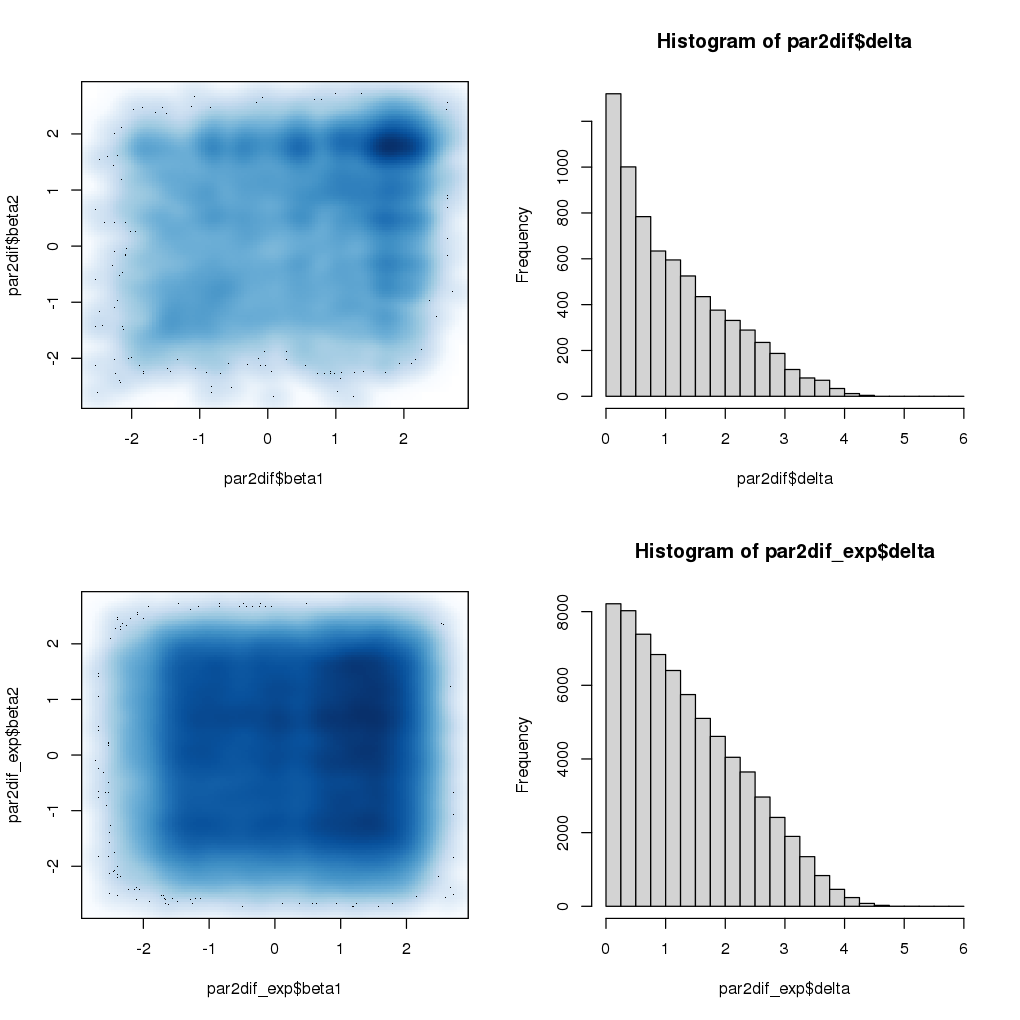

In [223]:
options(repr.plot.width = 8.5, repr.plot.height = 8.5)
layout(matrix(1:4, nrow = 2, byrow = FALSE))

smoothScatter(par2dif    $beta1, par2dif    $beta2)
smoothScatter(par2dif_exp$beta1, par2dif_exp$beta2)
hist(par2dif    $delta, breaks = (0:24)/4)
hist(par2dif_exp$delta, breaks = (0:24)/4)


In [224]:
t.test(par2dif[ , "delta"], par2dif_exp[ , "delta"])
t.test(par2dif[ par2dif$qval1 < 0.05, "delta"], par2dif[ par2dif_exp$qval1 < 0.05, "delta"])
t.test(par2dif[ par2dif$qval1 < 0.05 & par2dif$qval2 < 0.05, "delta"], par2dif[ par2dif_exp$qval1 < 0.05 & par2dif_exp$qval2 < 0.05, "delta"])



	Welch Two Sample t-test

data:  par2dif[, "delta"] and par2dif_exp[, "delta"]
t = -18.738, df = 8619.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2419376 -0.1961118
sample estimates:
mean of x mean of y 
 1.136765  1.355790 



	Welch Two Sample t-test

data:  par2dif[par2dif$qval1 < 0.05, "delta"] and par2dif[par2dif_exp$qval1 < 0.05, "delta"]
t = -0.23876, df = 10584, p-value = 0.8113
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04121718  0.03226660
sample estimates:
mean of x mean of y 
 1.138365  1.142841 



	Welch Two Sample t-test

data:  par2dif[par2dif$qval1 < 0.05 & par2dif$qval2 < 0.05, "delta"] and par2dif[par2dif_exp$qval1 < 0.05 & par2dif_exp$qval2 < 0.05, "delta"]
t = -3.9307, df = 7800.9, p-value = 8.544e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.13329547 -0.04458466
sample estimates:
mean of x mean of y 
 1.056684  1.145624 


# Test if promoter of paralogs with significant association with tissue and different direction are associated with different TFs (hypoxia and heart development)

In [225]:
tmpwd = "pipeline/5.1.expression_enrichments/paralogs"
dir.create(tmpwd, showWarnings = FALSE)

In [248]:
totest    = par2dif[par2dif$same_sign == FALSE & par2dif$qval1 < 0.05 & par2dif$qval2 < 0.05,]
promoters = fread("/frazer01/reference/private/Gencode.v34lift37/promoters.bed", sep = "\t", header = FALSE, data.table = FALSE)
genes_up  = promoters[ promoters[,4] %in% prot_info[ prot_info$gene_id %in% unique(c(totest[ totest$sign1 ==  1, "gene_id1"], totest[ totest$sign2 ==  1, "gene_id2"])), "transcript_id"],]
genes_dn  = promoters[ promoters[,4] %in% prot_info[ prot_info$gene_id %in% unique(c(totest[ totest$sign1 == -1, "gene_id1"], totest[ totest$sign2 == -1, "gene_id2"])), "transcript_id"],]

colnames(genes_up) = c("chrom", "from", "to", "transcript_id")
colnames(genes_dn) = c("chrom", "from", "to", "transcript_id")

genes_up  = merge(genes_up, prot_info[,c("transcript_id", "strand")])
genes_dn  = merge(genes_dn, prot_info[,c("transcript_id", "strand")])

genes_dn$score = 0
genes_up$score = 0

genes_up  = genes_up[order(genes_up[,"chrom"], genes_up[,"from"], genes_up[,"to"]),]
genes_dn  = genes_dn[order(genes_dn[,"chrom"], genes_dn[,"from"], genes_dn[,"to"]),]

genes_up_file_unmerged = paste(tmpwd, "genes_up.unmerged.bed", sep = "/")
genes_dn_file_unmerged = paste(tmpwd, "genes_dn.unmerged.bed", sep = "/")

genes_up_file = paste(tmpwd, "genes_up.bed", sep = "/")
genes_dn_file = paste(tmpwd, "genes_dn.bed", sep = "/")

fwrite(genes_up[,c("chrom", "from", "to", "transcript_id", "score", "strand")], genes_up_file_unmerged, sep = "\t", col.names = FALSE, row.names = FALSE)
fwrite(genes_dn[,c("chrom", "from", "to", "transcript_id", "score", "strand")], genes_dn_file_unmerged, sep = "\t", col.names = FALSE, row.names = FALSE)
fwrite(totest, paste(tmpwd, "paralogs.txt", sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)

system(paste("bedtools merge -c 4 -o distinct", "-i", genes_up_file_unmerged, ">", genes_up_file))
system(paste("bedtools merge -c 4 -o distinct", "-i", genes_dn_file_unmerged, ">", genes_dn_file))


In [249]:
length(unique(totest$cluster))
length(unique(c(totest$gene_id1, totest$gene_id2)))
nrow(totest)

[1] 475

[1] 1279

[1] 1181

## Run Homer standard

In [228]:
command_up_enr = paste("findMotifsGenome.pl", genes_up_file, "hg19", sub("\\.bed", "", genes_up_file), 
                       #"-find", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-size", 200
                      )

command_dn_enr = paste("findMotifsGenome.pl", genes_dn_file, "hg19", sub("\\.bed", "", genes_dn_file), 
                       #"-find", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-size", 200
                      )

command_up_vs_dn = paste("findMotifsGenome.pl", genes_up_file, "hg19", paste(tmpwd, "up_vs_down", sep = "/"), 
                       #"-find", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-bg", genes_dn_file,
                       "-size", 200
                      )

command_dn_vs_up = paste("findMotifsGenome.pl", genes_dn_file, "hg19", paste(tmpwd, "down_vs_up", sep = "/"), 
                       #"-find", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-bg", genes_up_file,
                       "-size", 200
                      )

message(command_up_enr)
message(command_dn_enr)
message(command_up_vs_dn)
message(command_dn_vs_up)


findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_up.bed hg19 pipeline/5.1.expression_enrichments/paralogs/genes_up -size 200

findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_dn.bed hg19 pipeline/5.1.expression_enrichments/paralogs/genes_dn -size 200

findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_up.bed hg19 pipeline/5.1.expression_enrichments/paralogs/up_vs_down -bg pipeline/5.1.expression_enrichments/paralogs/genes_dn.bed -size 200

findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_dn.bed hg19 pipeline/5.1.expression_enrichments/paralogs/down_vs_up -bg pipeline/5.1.expression_enrichments/paralogs/genes_up.bed -size 200



## Run Homer with HOCOMOCO motifs

In [250]:
command_up_enr = paste("findMotifsGenome.pl", genes_up_file, "hg19", sub("bed$", "hocomoco", genes_up_file), 
                       "-mknown", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-mcheck", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-nomotif",
                       "-size", 200
                      )

command_dn_enr = paste("findMotifsGenome.pl", genes_dn_file, "hg19", sub("bed$", "hocomoco", genes_dn_file), 
                       "-mknown", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-mcheck", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-nomotif",
                       "-size", 200
                      )

command_up_vs_dn = paste("findMotifsGenome.pl", genes_up_file, "hg19", paste(tmpwd, "up_vs_down.hocomoco", sep = "/"), 
                       "-mknown", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-mcheck", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-bg", genes_dn_file,
                       "-size", 200
                      )

command_dn_vs_up = paste("findMotifsGenome.pl", genes_dn_file, "hg19", paste(tmpwd, "down_vs_up.hocomoco", sep = "/"), 
                       "-mknown", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-mcheck", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-bg", genes_up_file,
                       "-size", 200
                      )

message(command_up_enr)
message(command_dn_enr)
message(command_up_vs_dn)
message(command_dn_vs_up)


findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_up.bed hg19 pipeline/5.1.expression_enrichments/paralogs/genes_up.hocomoco -mknown /frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif -mcheck /frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif -nomotif -size 200

findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_dn.bed hg19 pipeline/5.1.expression_enrichments/paralogs/genes_dn.hocomoco -mknown /frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif -mcheck /frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif -nomotif -size 200

findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_up.bed hg19 pipeline/5.1.expression_enrichments/paralogs/up_vs_down.hocomoco -mknown /frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif -mcheck /f

## Find HOCOMOCO motifs annotations

In [230]:
command_up_enr = paste("findMotifsGenome.pl", genes_up_file, "hg19", sub("bed$", "hocomoco_annot", genes_up_file), 
                       "-find", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-size", 200,
                       ">", sub("bed$", "hocomoco.txt", genes_up_file)
                      )

command_dn_enr = paste("findMotifsGenome.pl", genes_dn_file, "hg19", sub("bed$", "hocomoco_annot", genes_dn_file), 
                       "-find", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-size", 200,
                       ">", sub("bed$", "hocomoco.txt", genes_dn_file)
                      )

command_up_vs_dn = paste("findMotifsGenome.pl", genes_up_file, "hg19", paste(tmpwd, "up_vs_down.hocomoco_annot", sep = "/"), 
                       "-find", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-bg", genes_dn_file,
                       "-size", 200,
                       ">", paste(tmpwd, "up_vs_down.hocomoco.txt", sep = "/")
                      )

command_dn_vs_up = paste("findMotifsGenome.pl", genes_dn_file, "hg19", paste(tmpwd, "down_vs_up.hocomoco_annot", sep = "/"), 
                       "-find", "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif", 
                       "-bg", genes_up_file,
                       "-size", 200,
                       ">", paste(tmpwd, "down_vs_up.hocomoco.txt", sep = "/")
                      )

message(command_up_enr)
message(command_dn_enr)
message(command_up_vs_dn)
message(command_dn_vs_up)


findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_up.bed hg19 pipeline/5.1.expression_enrichments/paralogs/genes_up.hocomoco_annot -find /frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif -size 200 > pipeline/5.1.expression_enrichments/paralogs/genes_up.hocomoco.txt

findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_dn.bed hg19 pipeline/5.1.expression_enrichments/paralogs/genes_dn.hocomoco_annot -find /frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif -size 200 > pipeline/5.1.expression_enrichments/paralogs/genes_dn.hocomoco.txt

findMotifsGenome.pl pipeline/5.1.expression_enrichments/paralogs/genes_up.bed hg19 pipeline/5.1.expression_enrichments/paralogs/up_vs_down.hocomoco_annot -find /frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif -bg pipeline/5.1.expression_enrichments/paralogs/genes_dn.bed -size 200 > pipeline

In [256]:
#tf_up            = fread(paste(tmpwd, "up_vs_down.hocomoco/knownResults.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
#tf_dn            = fread(paste(tmpwd, "down_vs_up.hocomoco/knownResults.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
tf_up            = fread(paste(tmpwd, "genes_up.hocomoco/knownResults.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
tf_dn            = fread(paste(tmpwd, "genes_dn.hocomoco/knownResults.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
colnames(tf_up)  = c("model", "consensus", "pval", "logp", "qval", "in_n", "in_p", "out_n", "out_p")
colnames(tf_dn)  = c("model", "consensus", "pval", "logp", "qval", "in_n", "in_p", "out_n", "out_p")

tf_up$in_p       = as.numeric(gsub("%", "", tf_up$in_p ))
tf_up$out_p      = as.numeric(gsub("%", "", tf_up$out_p))
tf_dn$in_p       = as.numeric(gsub("%", "", tf_dn$in_p ))
tf_dn$out_p      = as.numeric(gsub("%", "", tf_dn$out_p))

tf_up$log2r      = log2(tf_up$in_p / tf_up$out_p)
tf_dn$log2r      = log2(tf_dn$in_p / tf_dn$out_p)

motifs           = fread("/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv", sep = "\t", header = TRUE, data.table = FALSE)
motifs$gene_name = motifs[, "Transcription factor"]
colnames(motifs) = gsub(" ", "_", tolower(colnames(motifs)))
tf_up            = merge(motifs[,c("model", "gene_name", "quality", "tf_family", "tf_subfamily")], tf_up, by = "model")
tf_dn            = merge(motifs[,c("model", "gene_name", "quality", "tf_family", "tf_subfamily")], tf_dn, by = "model")

tfs              = merge(tf_up, tf_dn[,c("model", "pval", "logp", "qval", "in_n", "in_p", "out_n", "out_p", "log2r")], by = "model", suffixes = c("_up", "_down"))

fwrite(tf_up, paste(tmpwd, "tf_binding.ipsc_cvpc.homer.paralogs.txt", sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)
fwrite(tf_dn, paste(tmpwd, "tf_binding.adult.homer.paralogs.txt"    , sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)
fwrite(tfs  , paste(tmpwd, "tf_binding.homer.paralogs.txt"          , sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)


In [257]:
cor.test(tfs$log2r_up, tfs$log2r_down)


	Pearson's product-moment correlation

data:  tfs$log2r_up and tfs$log2r_down
t = 1.9548, df = 399, p-value = 0.0513
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.0005352253  0.1934829002
sample estimates:
       cor 
0.09739913 


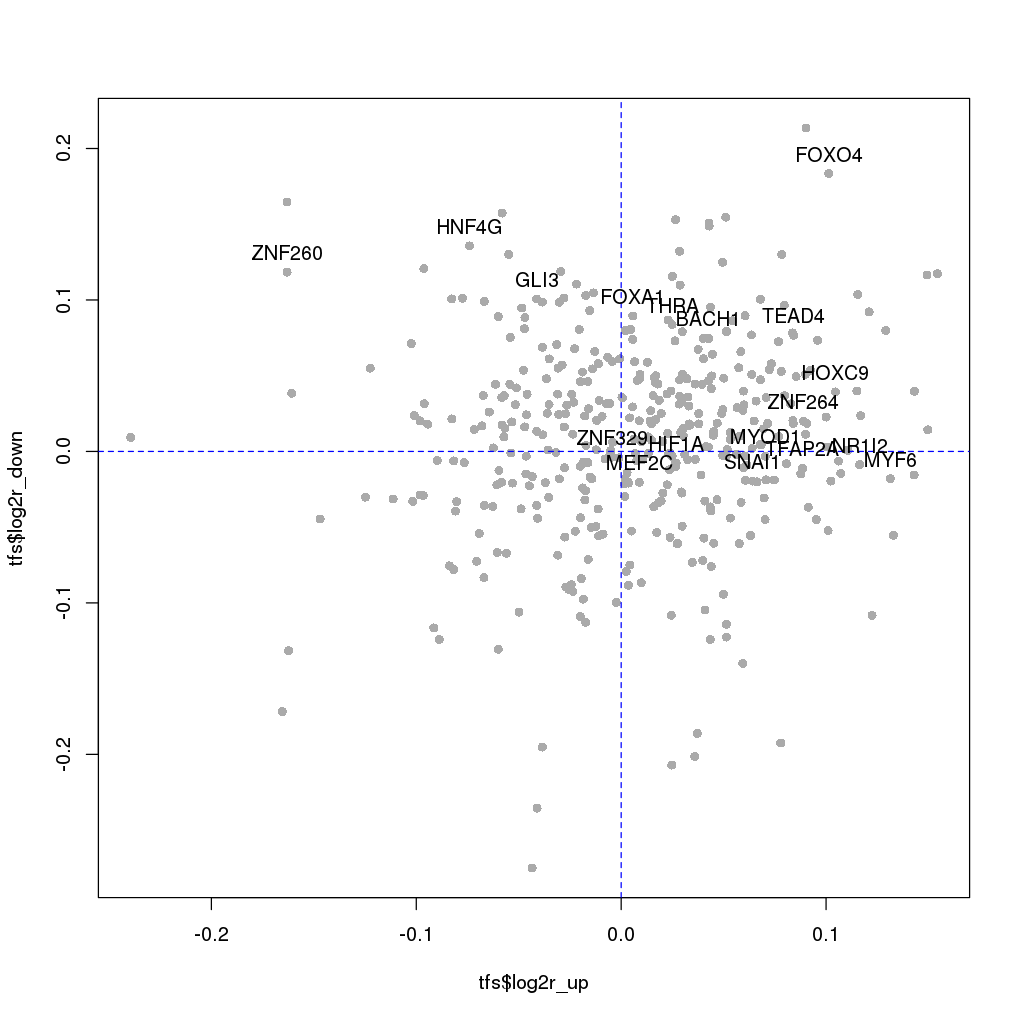

In [258]:
tfs$color = "#aaaaaa"
tfs[tfs$qval_up <= 0.05 & tfs$qval_down <= 0.05, "color"] = "#ff0000"
tfs[tfs$qval_up <= 0.05 & tfs$qval_down >  0.05, "color"] = "#0066CC"
tfs[tfs$qval_up >  0.05 & tfs$qval_down <= 0.05, "color"] = "#A52A56"

plot(tfs$log2r_up, tfs$log2r_down, pch = 16, col = tfs$color)

toplot = tfs[tfs$gene_name %in% c("MEF2C", "MYF6", "MYOD1", "SNAI1", "HOXC9", "TFAP2A", "TEAD4", "HIF1A", "FOXO4", "TEAD4", "GLI3", "THRA", "BACH1", "FOXA1", "HNF4G", "ZNF264", "NR1I2", "ZNF260", "ZNF329"),]
abline(h = 0, lty = "dashed", col = "#0000ff")
abline(v = 0, lty = "dashed", col = "#0000ff")

text(x = toplot$log2r_up, y = toplot$log2r_down, labels = toplot$gene_name, pos = 3)



In [259]:
suppressPackageStartupMessages(library(wordcloud))
suppressPackageStartupMessages(library(tm))

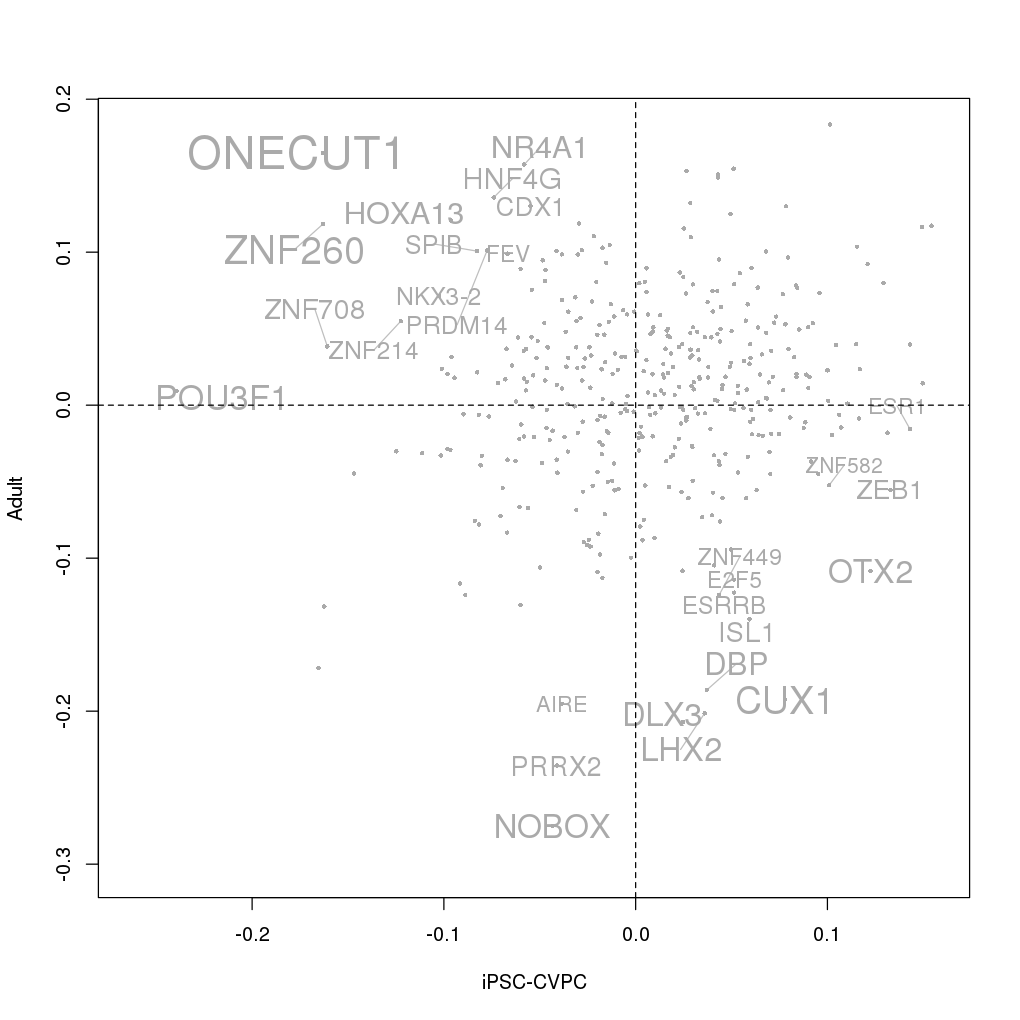

In [261]:
tfs$delta = tfs$log2r_up - tfs$log2r_down
#toplot    = tfs[tfs$color != "#aaaaaa" & abs(tfs$delta) > 0.15,]
toplot    = tfs[abs(tfs$delta) > 0.15,]

textplot(toplot$log2r_up, toplot$log2r_down, toplot$gene_name, cex = abs(toplot$delta)*7, col = toplot$color, xlim = range(toplot$log2r_up) * 1.1, ylim = range(toplot$log2r_down) * 1.1, xlab = "iPSC-CVPC", ylab = "Adult")
points  (tfs   $log2r_up, tfs   $log2r_down, col = tfs$color, pch = 16, cex = 0.5)
#plot(tfs$log2r1, tfs$log2r2, pch = 16, col = tfs$color)
#
#toplot = tfs[tfs$color != "#aaaaaa", ]
#toplot = rbind(head(toplot, n = 5), tail(toplot, n = 5))
abline(h = 0, lty = "dashed", col = "#000000")
abline(v = 0, lty = "dashed", col = "#000000")


# Functional enrichment of TFs

In [ ]:
gmt2list = function(gs)
{    
    indata = readLines(paste("input/phenotypes/msigdb", paste(gs, "v7.1.symbols.gmt", sep = "."), sep = "/"))
    indata = lapply(indata, function(x)
    {
        this = unlist(strsplit(x, "\t"))
        out  = list(gene_set = this[[1]], url = this[[2]], gene_names = this[3:length(this)])
        
        return(out)
    })
    names(indata) = unlist(lapply(indata, function(x){x$gene_set}))
    
    return(indata)
}

msigdb               = c("c2.cp.biocarta", "c2.cp.kegg", "c2.cp.reactome", "c5.bp", "c5.cc", "c5.mf", "h.all")
#msigdb               = c("h.all")
genesets2test        = lapply(msigdb, gmt2list)
names(genesets2test) = msigdb

In [ ]:
calculate_functional_enrichment_tissue_by_gene_set = function(tissue, gs, gene_set, diffexp)
{
    out        = data.frame(tissue = tissue, gs_source = gs, gene_set = gene_set[["gene_set"]], url = gene_set[["url"]])
    genes_in   = gene_set[["gene_names"]]
    diffexp$gs = FALSE
    
    if(nrow(diffexp[diffexp$gene_name %in% genes_in,]) > 1)
    {
        diffexp[diffexp$gene_name %in% genes_in, "gs"] = TRUE

        test = t.test(diffexp[diffexp$gs == TRUE, "log2r"], diffexp[diffexp$gs == FALSE, "log2r"])
        out  = cbind(out, data.frame(n_genes = nrow(diffexp[diffexp$gs == TRUE, ]), ttest_estimate_in = test$estimate[[1]], ttest_estimate_out = test$estimate[[2]], ttest_ci1 = test$conf.int[[1]], ttest_ci2 = test$conf.int[[2]], ttest_pval = test$p.value))
    }else
    {
        out  = cbind(out, data.frame(n_genes = 0, ttest_estimate_in  = NA, ttest_estimate_out = NA, ttest_ci1     = NA, ttest_ci2      = NA, ttest_pval = NA))
    }
    return(out)
}

tests = as.data.frame(rbindlist(lapply(msigdb, function(gs)
{
    message(gs)
    gene_sets = genesets2test[[gs]]
    as.data.frame(rbindlist(lapply(gene_sets, function(gene_set)
    {
        #message(gene_set[["gene_set"]])
        out = rbind(calculate_functional_enrichment_tissue_by_gene_set("iPSC-CVPC", gs, gene_set, tf_up),
                    calculate_functional_enrichment_tissue_by_gene_set("adult"    , gs, gene_set, tf_dn))
        return(out)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

tests           = tests[is.na(tests$ttest_estimate_in) == FALSE, ]
tests$ttest_fdr = p.adjust(tests$ttest_pval, method = "BH")

fwrite(tests, paste(tmpwd, "functional_enrichment.homer.paralogs.txt", sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)

